In [1]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import lightgbm as lgb

pd.set_option('display.max_columns', None)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
def reduce_mem_usage(df):
    """ 
        iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        if not col.endswith("D") and not pd.api.types.is_datetime64_any_dtype(df[col]):
            col_type = df[col].dtype
            if str(col_type)=="category":
                continue

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                continue
    end_mem = df.memory_usage().sum() / 1024**2    
    return df

In [3]:
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [4]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        df = df.drop("MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [5]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col) for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col) for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col) for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col) for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col) for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [6]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
        chunks.append(df)
        
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    
    return df

In [7]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            #year_decision = pl.col("date_decision").dt.year(),
            month_decision = pl.col("date_decision").dt.month(),
            #week_decision = pl.col("date_decision").dt.week(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [8]:
def preprocess_data(data, features, imputer):
    data[features] = imputer.transform(data[features])
    return data

In [9]:
def decompose_data(data, imputer):
    data = imputer.transform(data)
    return data

In [10]:
def scale_data(data, imputer):
    data = imputer.transform(data)
    return data

In [11]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [12]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [13]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [14]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 473)


In [15]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [16]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 472)


In [17]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 362)
test data shape:	 (10, 361)


In [18]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

In [19]:
#df_train = reduce_mem_usage(df_train)
#df_test = reduce_mem_usage(df_test)

In [20]:
selected_features = df_train.drop('target', axis=1).select_dtypes(include=['float64', 'int64']).columns.tolist()

imputer = SimpleImputer(strategy='constant', fill_value=0)
df_train[selected_features] = imputer.fit_transform(df_train[selected_features])

df_test = preprocess_data(df_test, selected_features, imputer)

In [21]:
del data_store

gc.collect()

0

In [22]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (100, 100)


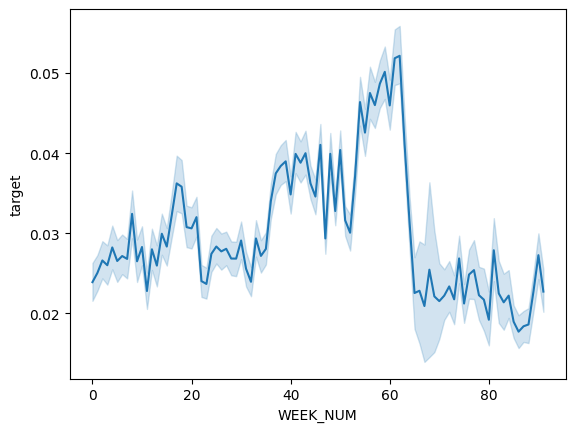

In [23]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

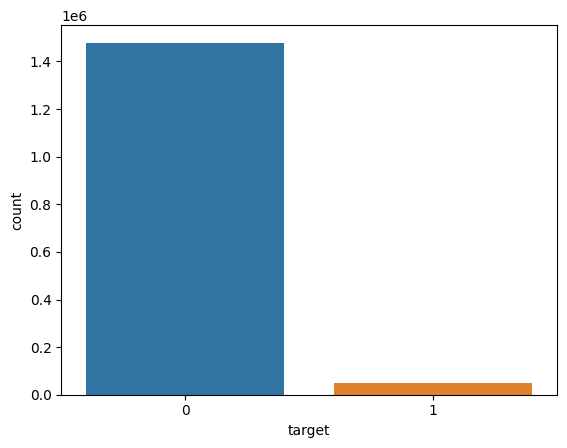

In [24]:
sns.countplot(x='target', data=df_train)
plt.show()

In [25]:
a1 = df_train.loc[df_train['target'] == 0, 'amount_4527230A'].value_counts().loc[0] / len(df_train[df_train['target'] == 0])
a2 = df_train.loc[df_train['target'] == 1, 'amount_4527230A'].value_counts().loc[0] / len(df_train[df_train['target'] == 1])

display(df_train.loc[df_train['target'] == 0, 'amount_4527230A'].shape)
display(a1)
print('------------------')
display(df_train.loc[df_train['target'] == 1, 'amount_4527230A'].shape)
display(a2)

(1478665,)

0.7024004761051353

------------------


(47994,)

0.627495103554611

In [26]:
b1 = df_train.loc[df_train['target'] == 0, 'pmtamount_36A'].value_counts().loc[0] / len(df_train[df_train['target'] == 0])
b2 = df_train.loc[df_train['target'] == 1, 'pmtamount_36A'].value_counts().loc[0] / len(df_train[df_train['target'] == 1])

display(df_train.loc[df_train['target'] == 0, 'pmtamount_36A'].shape)
display(b1)
print('------------------')
display(df_train.loc[df_train['target'] == 1, 'pmtamount_36A'].shape)
display(b2)

(1478665,)

0.6834110498321121

------------------


(47994,)

0.7054840188356878

In [27]:
c1 = df_train.loc[df_train['target'] == 0, 'amount_4917619A'].value_counts().loc[0] / len(df_train[df_train['target'] == 0])
c2 = df_train.loc[df_train['target'] == 1, 'amount_4917619A'].value_counts().loc[0] / len(df_train[df_train['target'] == 1])

display(df_train.loc[df_train['target'] == 0, 'amount_4917619A'].shape)
display(c1)
print('------------------')
display(df_train.loc[df_train['target'] == 1, 'amount_4917619A'].shape)
display(c2)

(1478665,)

0.9007618358451711

------------------


(47994,)

0.9168229362003584

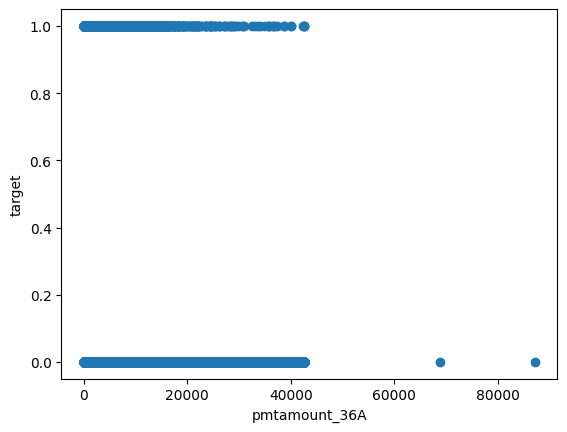

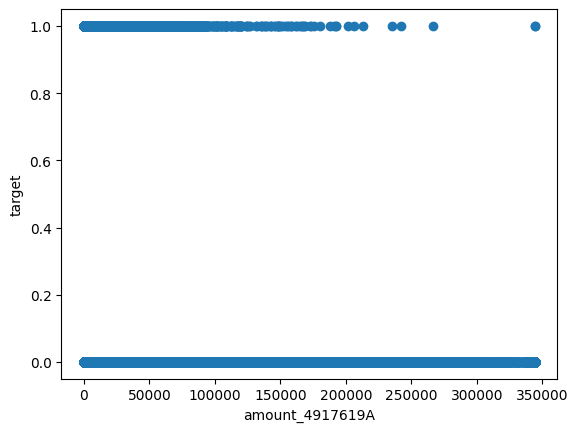

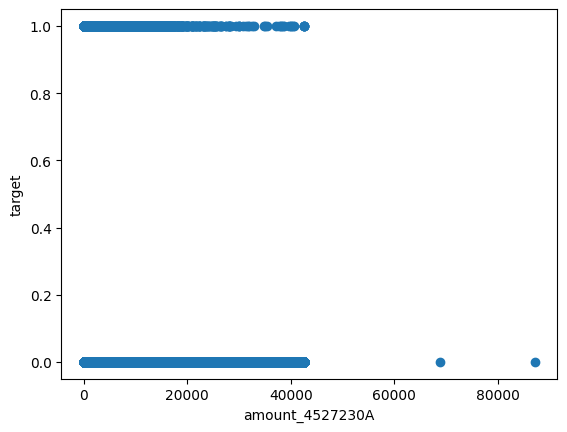

In [28]:
for col in ['pmtamount_36A', 'amount_4917619A', 'amount_4527230A']:
    plt.scatter(df_train[col], df_train["target"])
    plt.xlabel(col)
    plt.ylabel("target")
    plt.show()

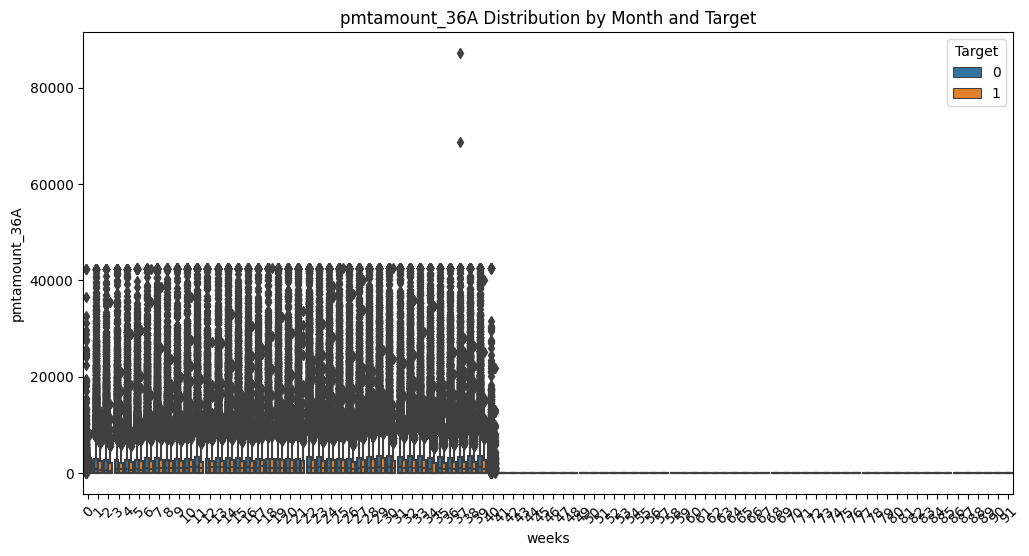

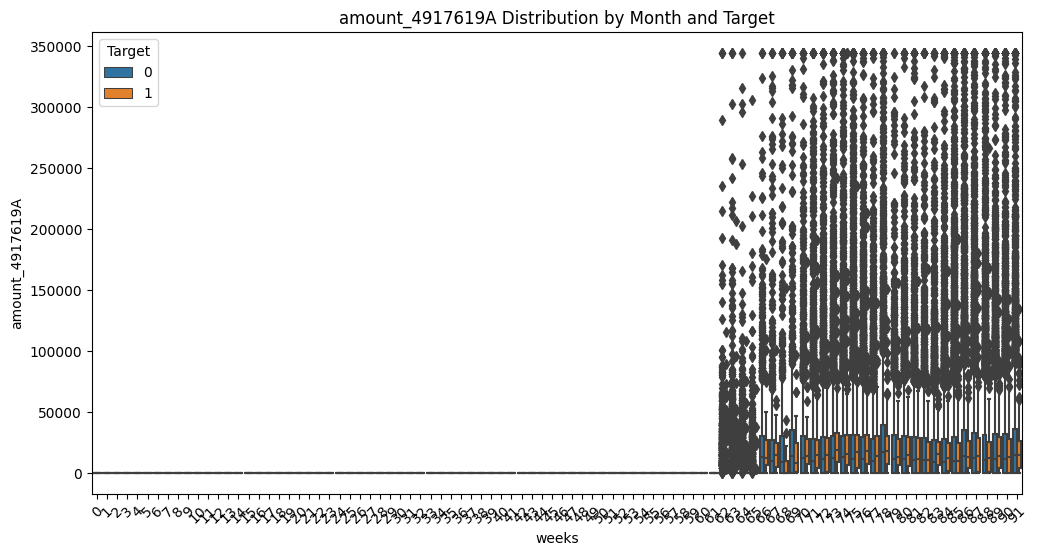

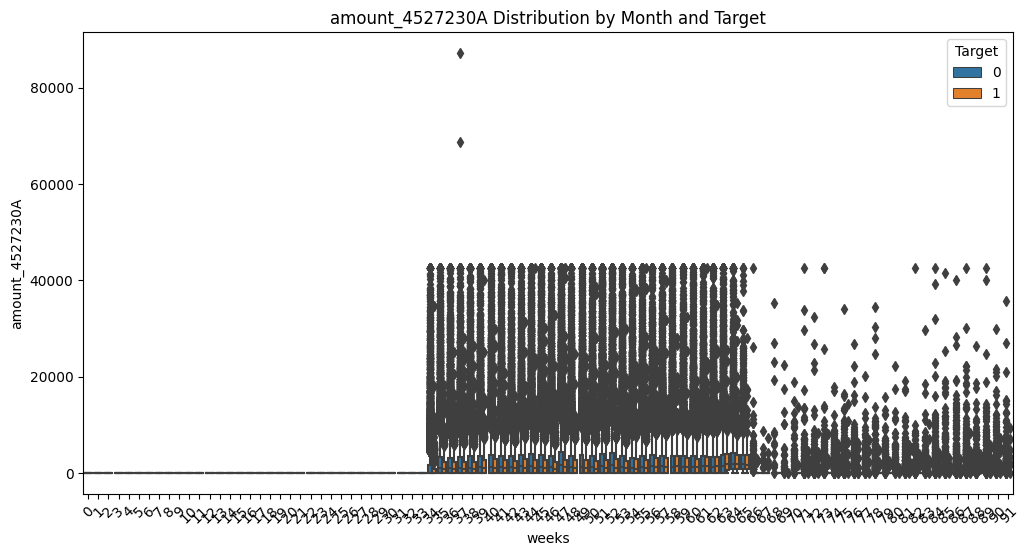

In [29]:
for col in ['pmtamount_36A', 'amount_4917619A', 'amount_4527230A']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='WEEK_NUM', y=col, hue='target', data=df_train)
    plt.xlabel('weeks')
    plt.ylabel(col)
    plt.title(f'{col} Distribution by Month and Target')
    plt.xticks(rotation=45)
    plt.legend(title='Target')
    plt.show()

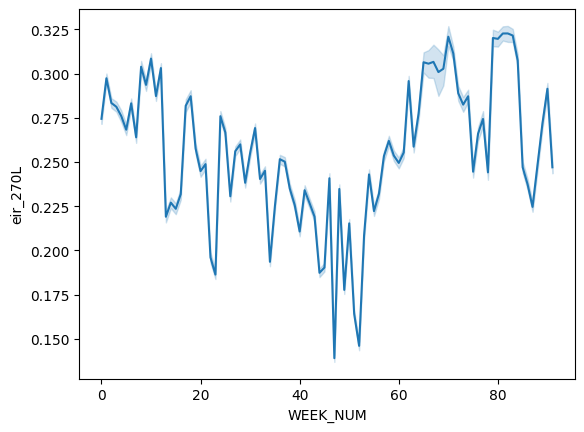

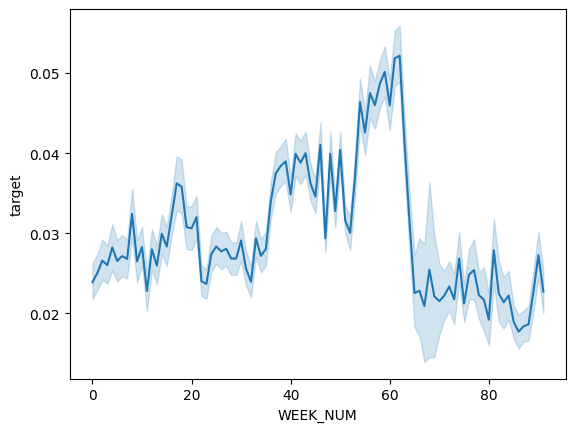

In [30]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="eir_270L",
)
plt.show()

sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

In [31]:
#df_train['eir_270L_trend'] = df_train['eir_270L'].rolling(window=4).mean()  # Moving average
#df_train['eir_270L_volatility'] = df_train['eir_270L'].rolling(window=4).std()  # Volatility
#df_train['eir_270L_lag_1'] = df_train['eir_270L'].shift(1)  # Lag feature
#df_train['eir_270L_lag_2'] = df_train['eir_270L'].shift(2)  # Another lag feature
#df_train['rate_of_change'] = df_train['eir_270L'].pct_change()  # Rate of change

In [32]:
#df_test['eir_270L_trend'] = df_train['eir_270L'].rolling(window=4).mean()  # Moving average
#df_test['eir_270L_volatility'] = df_train['eir_270L'].rolling(window=4).std()  # Volatility
#df_test['eir_270L_lag_1'] = df_train['eir_270L'].shift(1)  # Lag feature
#df_test['eir_270L_lag_2'] = df_train['eir_270L'].shift(2)  # Another lag feature
#df_test['rate_of_change'] = df_train['eir_270L'].pct_change()  # Rate of change

In [33]:
df_train['median_pmtamount'] = df_train[['pmtamount_36A', 'amount_4527230A', 'amount_4917619A']].mean(axis=1)
df_test['median_pmtamount'] = df_test[['pmtamount_36A', 'amount_4527230A', 'amount_4917619A']].mean(axis=1)

In [34]:
# Data preparation
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM", "date_decision"])
X = X[X.select_dtypes(include=['float64', 'int64']).columns.tolist()]
y = df_train["target"]

# Add constant for intercept
X = sm.add_constant(X)

In [35]:
X = X.dropna(axis=1, inplace=False)

In [36]:
cols = X.drop('const', axis=1).columns.tolist()

In [37]:
X = np.asarray(X)

In [38]:
y = np.asarray(y)

In [39]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [40]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.98)  # Preserve 95% of variance
X = pca.fit_transform(X)

In [41]:
# Fit the logistic regression model
model = sm.Logit(y, X)

In [42]:
model = model.fit_regularized(maxiter=100)

/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6500288240624371
            Iterations: 80
            Function evaluations: 249
            Gradient evaluations: 80


In [43]:
# Predict probabilities
y_pred = model.predict(X)

In [44]:
# Calculate AUC
auc = roc_auc_score(y, y_pred)
print("AUC:", auc)

AUC: 0.6271429121967786


In [45]:
"""
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM", "date_decision"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False) # n=5

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 5,
    "learning_rate": 0.05,
    "n_estimators": 1000, # n=1000 - 200
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_moddels = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

model = VotingModel(fitted_models)
"""

'\nX = df_train.drop(columns=["target", "case_id", "WEEK_NUM", "date_decision"])\ny = df_train["target"]\nweeks = df_train["WEEK_NUM"]\n\ncv = StratifiedGroupKFold(n_splits=5, shuffle=False) # n=5\n\nparams = {\n    "boosting_type": "gbdt",\n    "objective": "binary",\n    "metric": "auc",\n    "max_depth": 5,\n    "learning_rate": 0.05,\n    "n_estimators": 1000, # n=1000 - 200\n    "colsample_bytree": 0.8,\n    "colsample_bynode": 0.8,\n    "verbose": -1,\n    "random_state": 42,\n    "device": "gpu",\n}\n\nfitted_moddels = []\n\nfor idx_train, idx_valid in cv.split(X, y, groups=weeks):\n    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]\n    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]\n\n    model = lgb.LGBMClassifier(**params)\n    model.fit(\n        X_train, y_train,\n        eval_set=[(X_valid, y_valid)],\n        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]\n    )\n\n    fitted_models.append(model)\n\nmodel = VotingModel(fitted_models)\n'

In [46]:
X_test = df_test[cols + ['case_id']]
X_test = X_test.set_index("case_id")

In [47]:
X_test = sm.add_constant(X_test)
X_test = scale_data(X_test, scaler)
X_test = decompose_data(X_test, pca)

y_pred = model.predict(X_test)

#y_pred = pd.Series(model.predict(X_test)[:, 1], index=X_test.index)

In [48]:
y_pred

array([0.3189378 , 0.70906279, 0.65987458, 0.4326515 , 0.48350537,
       0.44218346, 0.42493845, 0.47799385, 0.53834156, 0.43344327])

In [49]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

In [50]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm

Check null:  False


,score
case_id,
57543,0.318938
57549,0.709063
57551,0.659875
57552,0.432652
57569,0.483505
57630,0.442183
57631,0.424938
57632,0.477994
57633,0.538342


In [51]:
df_subm.to_csv("submission.csv")